In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysabr as pysabr
from pysabr import Hagan2002LognormalSABR
from pysabr import hagan_2002_lognormal_sabr as sabr
from pysabr.black import lognormal_call
import openbb
from openbb import obb

import yfinance as yf

In [99]:
from decouple import config

In [100]:
# Get the tokens for API access
api_key = config("INTRINIO_KEY")
obb_key=config("OBB_KEY")

from openbb import obb
obb.account.login(pat=obb_key)

# Persist changes in OpenBB Hub
obb.account.save()


obb.user.credentials.intrinio_api_key=api_key

In [101]:
symbol = "SPY"
expiration = "2026-12-18"
#spy = obb.derivatives.options.chains(symbol,provider='intrinio')

spy_data = yf.Ticker(symbol)

In [102]:

spy=spy_data.option_chain(date=expiration)

calls = spy.calls
puts=spy.puts

In [103]:

dec_2026_c = calls.set_index("strike")
dec_2026_c["mid"] = (dec_2026_c.ask + dec_2026_c.bid) / 2
dec_2026_c
strikes = dec_2026_c.index
vols = dec_2026_c.impliedVolatility * 100

In [104]:
dec_2026_p = puts.set_index("strike")
dec_2026_p["mid"] = (dec_2026_c.ask + dec_2026_c.bid) / 2
dec_2026_p

,contractSymbol,lastTradeDate,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,mid
strike,,,,,,,,,,,,,,
200.0,SPY261218P00200000,2024-08-05 20:11:26+00:00,2.48,1.70,2.20,0.780000,45.882350,95.0,1843,0.338752,False,REGULAR,USD,327.200
210.0,SPY261218P00210000,2024-08-05 19:54:43+00:00,3.63,0.01,4.30,1.970000,118.674710,2.0,98,0.368109,False,REGULAR,USD,318.355
220.0,SPY261218P00220000,2024-08-05 19:20:09+00:00,2.90,0.01,3.50,0.550000,23.404264,27.0,91,0.336371,False,REGULAR,USD,309.550
230.0,SPY261218P00230000,2024-08-02 16:53:23+00:00,2.30,2.15,8.00,0.000000,0.000000,1.0,18,0.387610,False,REGULAR,USD,300.795
240.0,SPY261218P00240000,2024-08-05 16:14:26+00:00,3.90,0.00,9.60,1.810000,86.602880,2.0,40,0.388403,False,REGULAR,USD,292.065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780.0,SPY261218P00780000,2024-05-06 13:43:18+00:00,265.98,0.00,252.31,0.000000,0.000000,1.0,0,0.000010,True,REGULAR,USD,3.395
785.0,SPY261218P00785000,2024-04-03 13:36:19+00:00,266.70,271.39,276.00,0.000000,0.000000,1.0,0,0.204216,True,REGULAR,USD,2.755
800.0,SPY261218P00800000,2024-08-05 18:12:58+00:00,281.20,276.62,286.53,24.480011,9.535685,12.0,12,0.177376,True,REGULAR,USD,2.450


In [105]:
stickes=jan_2026_c.index
vols=jan_2026_c.impliedVolatility*100

We then compute the mid price to get a more accurate picture of implied volatility. We’ll need the strikes and market implied volatilities, too.
The mid price provides a more accurate and stable estimate for the market price of an option compared to using either the bid or ask prices alone. This is crucial when calculating implied volatility (IV), which is a key measure in options pricing and risk management. Here’s why the mid price is helpful:

Importance of Mid Price
Reduced Noise: The bid price is the highest price a buyer is willing to pay, and the ask price is the lowest price a seller is willing to accept. The mid price, calculated as the average of the bid and ask prices, reduces the noise and provides a more balanced view of the market price.

Better Estimation: Since IV is derived from the option price, using the mid price ensures that the estimated IV is less affected by temporary imbalances or wide bid-ask spreads. This is particularly important in less liquid markets or for options with wide spreads.

Market Consensus: The mid price represents a consensus value between buyers and sellers, making it a better reflection of the true market value. This leads to a more accurate and reliable implied volatility estimate.

In [106]:
#calculating the future prices uisng put-call parity relationship
f = (
    (dec_2026_c.mid - dec_2026_p.mid-strikes)
    .dropna()
    .abs()
    .sort_values()
    .index[0]
)
t = (pd.Timestamp(expiration) - pd.Timestamp.now()).days / 365

The beta parameter governs the shape of the forward rate, which influences the shape of the implied volatility smile. A beta of 1 implies a lognormal distribution, which is consistent with the Black-Scholes model. Moving beta away from 1 allows for different shapes of volatility smiles. In practice, setting beta to 0.5 is usually a safe bet.

In [107]:
beta = 0.5

sabr_lognormal = Hagan2002LognormalSABR(
    f=f,
    t=t,
    beta=beta
)

alpha, rho, volvol = sabr_lognormal.fit(strikes, vols)

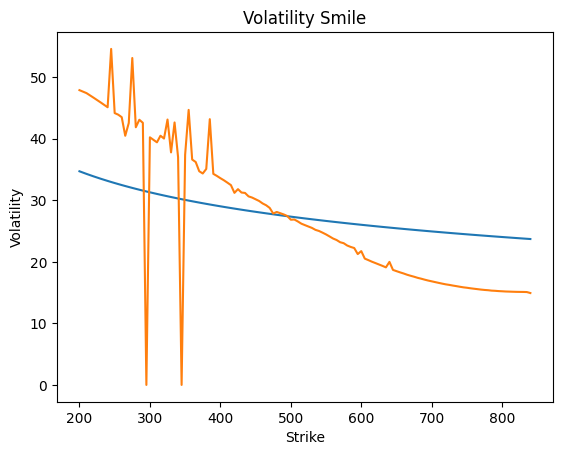

In [108]:
calibrated_vols = [
    sabr.lognormal_vol(strike, f, t, alpha, beta, rho, volvol) * 100
    for strike in strikes
]
plt.plot(
    strikes, 
    calibrated_vols
)

plt.xlabel("Strike")
plt.ylabel("Volatility")
plt.title("Volatility Smile")
plt.plot(strikes, vols)
plt.show()

This code generates a lognormal volatility for each strike in our options chain and plots it. The result is a fitted volatility smile (or smirk in this case), along with the market based volatility smile.

<Axes: xlabel='strike'>

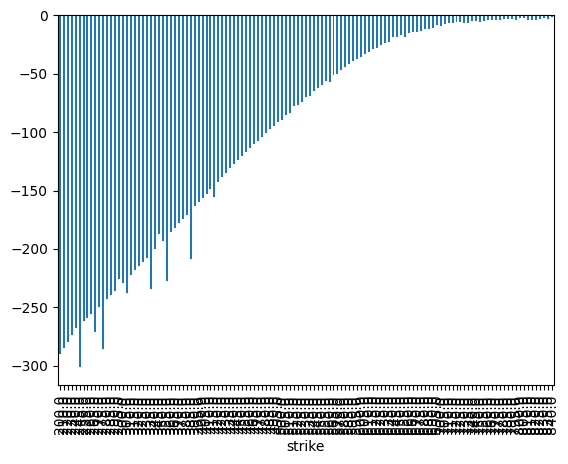

In [110]:
black_values = []
for strike, calibrated_vol in zip(strikes.tolist(), calibrated_vols):
    black_value = lognormal_call(
        strike, 
        f, 
        t, 
        calibrated_vol / 100, 
        0.05, 
        cp="call"
    )
    black_values.append(black_value)


option_values = pd.DataFrame(
    {
        "black": black_values,
        "market": dec_2026_c.mid
    },
    index=strikes
)


(option_values.black - option_values.market).plot.bar()

The result is a bar chart which demonstrates the model error for each strike price based on the calibrated implied volatility from the SABR model.

